<a href="https://colab.research.google.com/github/stepan-zykov/DLS/blob/main/AutoEncoder/Conditional_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import IPython.display as display

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir('/content/drive/MyDrive/DLS/HW/HW7_AutoEncoder/')

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

# Загрузка данных

При загрузке использрем трансформеры. Переводим картинку в тензор, убираем единичную размерность. Метки классов кодируем с помощью OHE.

In [103]:
train_dataset = datasets.MNIST(root = './cva_mnist_data/',
                               train = True,
                               transform = Compose([ToTensor(),
                                                    Lambda(lambda x: torch.squeeze(x))]),
                               target_transform = Lambda(lambda x: F.one_hot(torch.tensor(x), 10)),
                               download = True)

val_dataset = datasets.MNIST(root = './cva_mnist_data/',
                               train = False,
                               transform = Compose([ToTensor(),
                                                    Lambda(lambda x: torch.squeeze(x))]),
                               target_transform = Lambda(lambda x: F.one_hot(torch.tensor(x), 10)),
                               download = False)

In [104]:
batch_size = 60
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Создание класса модели

Особенностью работы Conditional VAE являет подача метки класса на декодер. Для этого в методе decode сконкатенируем OHE векторы с метками классов, а в декодере изменим input

In [105]:
class CVAE(nn.Module):
    def __init__(self, latent_size=20, num_of_classes=10):
        super(CVAE, self).__init__()
        self.num_of_classes = num_of_classes
        self.flatten = nn.Flatten()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28*1, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=self.latent_size*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_size + num_of_classes, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=28*28*1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = x.view(-1, 2, self.latent_size)
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        sd = torch.exp(0.5 * log_var)
        return mu, sd

    def gaussian_sampler(self, mu, sd):
        if self.training:
            z = torch.randn_like(sd)
            x = z * sd + mu
            return x
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, mu, sd, y):
        x = self.gaussian_sampler(mu, sd)
        x = torch.cat((x, y), dim=1)
        reconstructed = self.decoder(x)
        return reconstructed

    def forward(self, x, y):
        mu, sd = self.encode(x)
        reconstructed = self.decode(mu, sd, y).view(-1, 28, 28)
        return mu, sd, reconstructed

# Создадим функцию потерь

In [114]:
def log_likelihood(x, reconstructed):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstructed, x)

def KL_divergence(mu, sd):
    loss = -0.5 * torch.sum(1 + torch.log(sd**2) - mu**2 - sd**2)
    return loss

def loss_cvae(x, reconstructed, mu, sd):
    return (KL_divergence(mu, sd) + log_likelihood(x, reconstructed))/2/28/28

# Инициализируем модель, функцию потерь, оптимизатор

In [150]:
LATENT_SIZE = 20
NUM_CLASSES = 10
cvae = CVAE(LATENT_SIZE, NUM_CLASSES)
criterion = loss_cvae
optimizer = torch.optim.Adam(params=cvae.parameters())

## Функции для визуального контроля за обучаением модели

In [140]:
def compare_pictures_vae(gt, rec):
    """
    Функция получает на вход ихсодные картинки и восстановленные картинки, вытянутые в векторы.
    Выводит соответствующие изображения, одно под другим
    """
    rec = rec.cpu().detach().numpy()
    gt = gt.cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(8, 3))
    axes = axes.flatten()
    for i, photo in enumerate(np.concatenate([gt, rec])):
        photo = np.clip(photo, 0, 1)
        axes[i].imshow(photo, cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [141]:
def losses_chart(train_losses, val_losses):
    """
    Функция получает списки лоссов на трейне и валидации и отрисовывает графики
    """
    epoch = len(train_losses)
    plt.plot(range(1, epoch + 1), train_losses, label = 'Training Loss')
    plt.plot(range(1, epoch + 1), val_losses, label = 'Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Функция для обучения модели

In [142]:
def train_cvae(model, loss_fn, optimizer, train_loader, val_loader, n_epochs):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in tqdm(range(n_epochs)):
        train_loss_per_epoch, val_loss_per_epoch = [], []
        model.train()
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            mu, sd, reconstructed = model(X, y)
            loss = loss_fn(X, reconstructed, mu, sd)
            loss.backward()
            optimizer.step()
            train_loss_per_epoch.append(loss.detach().cpu().item())
        train_loss = sum(train_loss_per_epoch) / len(train_loss_per_epoch)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(val_loader):
                X = X.to(device)
                y = y.to(device)
                mu, sd, reconstructed = model(X, y)
                loss = loss_fn(X, reconstructed, mu, sd)
                val_loss_per_epoch.append(loss.detach().cpu().item())
        val_loss = sum(val_loss_per_epoch) / len(val_loss_per_epoch)
        val_losses.append(val_loss)

        display.clear_output(wait=True) # clear previous output
        for i in range(0, 11, 5):
            compare_pictures_vae(X[i:i+5], reconstructed[i:i+5])
        losses_chart(train_losses, val_losses)
        print(f"Epoch [{epoch + 1}/{n_epochs}],",
              f"\nTraining loss: {np.mean(train_loss):.4f},",
              f"\nValidation loss: {np.mean(val_loss):.4f}")

    return train_losses, val_losses


# Обучение модели

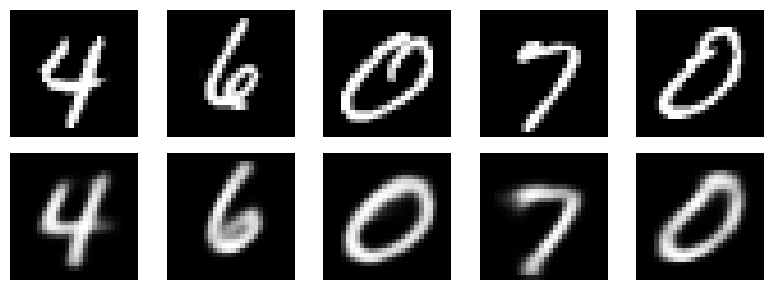

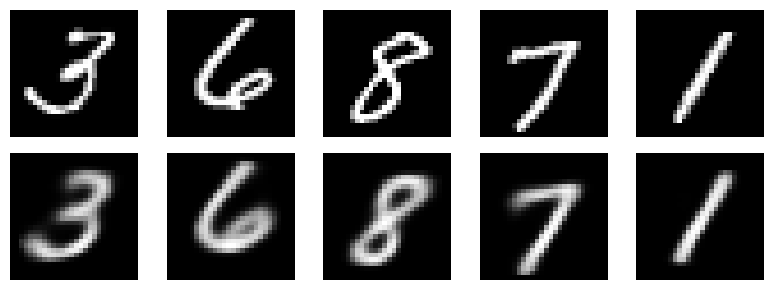

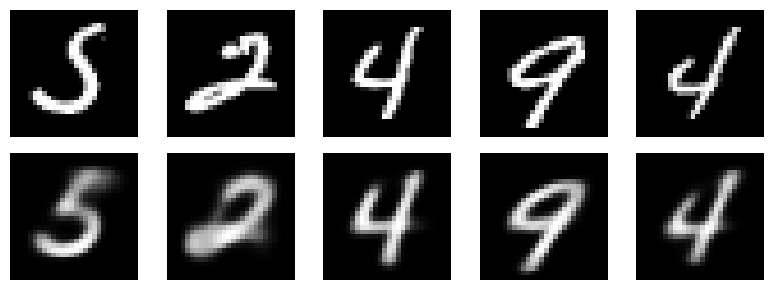

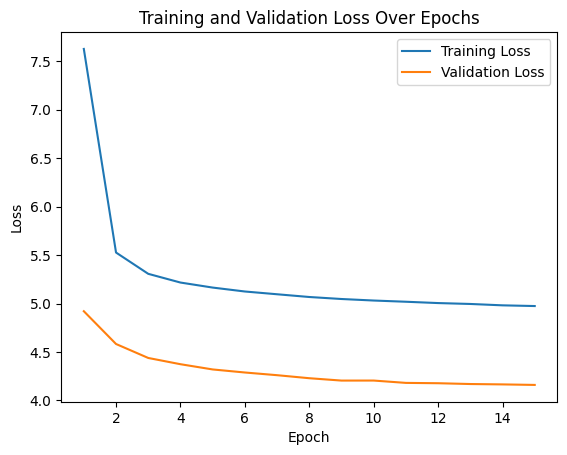

Epoch [15/15], 
Training loss: 4.9740, 
Validation loss: 4.1601


In [143]:
train_losses, val_losses = train_cvae(cvae, criterion, optimizer, train_loader, val_loader, 15)

In [144]:
torch.save(cvae, 'cvae.pt')

In [151]:
device = 'cpu:0' if torch.cuda.is_available() else 'cpu'
cvae = torch.load('cvae.pt').to(device)

### Sampling


In [154]:
num_pictures = 10
mu = torch.tensor(np.array([np.random.normal(0, 1, LATENT_SIZE) for i in range(num_pictures)])).to(device)
sd = torch.tensor(np.array([np.random.normal(0, 1, LATENT_SIZE) for i in range(num_pictures)])).to(device)
y = torch.tensor([5 for _ in range(num_pictures)])

Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?